# Présentation des données

On cherche à généré des scénarios économiques. Plus précisément, on veut pour un actif $ (S_t)_{t \in \mathbb{N}} $ observé généré une série $ (\tilde{S}_h, \tilde{S}_{h+1} ... , \tilde{S}_{h+k})$ de variables dont la distribution est proche de $(S_h, S_{h+1}, \ldots, S_{h+k})$ (les vraies valeurs potentiellement observées).

On utilise donc des données sur le prix d'actifs financiers. Notre dataframe est composé de 28777 observations, 12 actifs financiers différents , ainsi que 2000 à 2500 observations par actif.

In [17]:
import pandas as pd
import numpy as np
from utils.create_data import simple_plot_date
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import seaborn as sb
from statsmodels.tsa.stattools import adfuller, acf


In [6]:
xls = pd.ExcelFile('./data/EnsaeGANData.xlsx')
print(xls.sheet_names)
Check = pd.read_excel(xls, 'Check')
AssetTS = pd.read_excel(xls, 'AssetTS')
Assumption = pd.read_excel(xls, 'Assumption')

['Check', 'AssetTS', 'Assumption']


In [7]:
#Check.head(10)
AssetTS.head(10)
#Assumption.head(10)

,ASSETTYPE,ASSETSUBTYPE,ASSETNAME,ISHEDGED,Date,PRICE,MonthYear,IsLastDayMonth
0,Alternative,Property,Global Property USD Unhedged,False,1999-02-28,889.64,1999/02,True
1,Alternative,Property,Global Property USD Unhedged,False,1999-03-31,916.07,1999/03,True
2,Alternative,Property,Global Property USD Unhedged,False,1999-04-30,1006.43,1999/04,True
3,Alternative,Property,Global Property USD Unhedged,False,1999-05-31,983.72,1999/05,True
4,Alternative,Property,Global Property USD Unhedged,False,1999-06-30,1005.67,1999/06,True
5,Alternative,Property,Global Property USD Unhedged,False,1999-07-31,992.68,1999/07,True
6,Alternative,Property,Global Property USD Unhedged,False,1999-08-31,982.74,1999/08,True
7,Alternative,Property,Global Property USD Unhedged,False,1999-09-30,941.42,1999/09,True
8,Alternative,Property,Global Property USD Unhedged,False,1999-10-31,928.73,1999/10,True
9,Alternative,Property,Global Property USD Unhedged,False,1999-11-30,953.56,1999/11,True


In [8]:
AssetTS['MonthYear'] = pd.to_datetime(AssetTS['MonthYear'], format='%Y/%m')
AssetTS_true = AssetTS[AssetTS['IsLastDayMonth'] == True]
AssetTS.ASSETNAME.value_counts()
#AssetTS.ASSETSUBTYPE.value_counts()
#AssetTS.ASSETTYPE.value_counts()
#print(AssetTS.info())

ASSETNAME
Europe ex UK Equity - USD Unhedged    2572
US Equity USD Unhedged                2519
UK Equity - USD Unhedged              2514
Global Property USD Unhedged          2507
Global Government Bond USD Hedged     2503
UK Government Bond - USD Hedged       2495
Liquidity USD Unhedged                2483
US Government Bond USD Unhedged       2439
USD Corporate Bond - USD Unhedged     2429
US High Yield Bond - USD Unhedged     2332
Liquidity EUR Unhedged in USD         2085
Liquidity GBP Unhedged in USD         1899
Name: count, dtype: int64

La variable ``DATE`` nous donne la date pour chaque actif considéré. On peut donc commencer par visualiser la trajectoire des actifs.

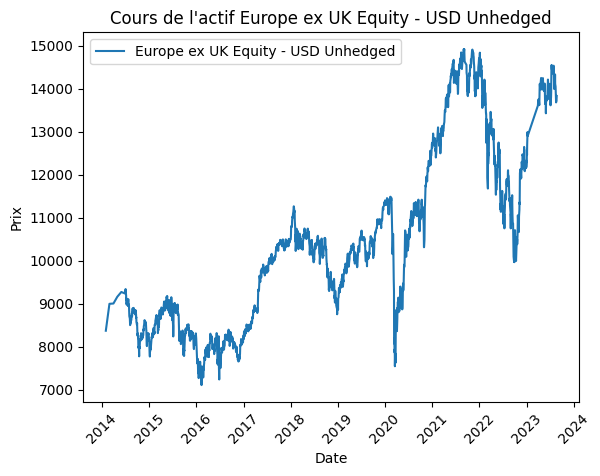

In [9]:
actif = "Europe ex UK Equity - USD Unhedged"
year = 2014
simple_plot_date(AssetTS[AssetTS['ASSETNAME']==actif]['Date'],AssetTS[AssetTS['ASSETNAME']==actif]['PRICE'],year, f"Cours de l'actif {actif}", f"{actif}")

In [10]:
liste_actifs = ["UK Equity - USD Unhedged",              
                "US Equity USD Unhedged",  
                "Europe ex UK Equity - USD Unhedged", 
                "USD Corporate Bond - USD Unhedged",
                "Global Property USD Unhedged",          
                "Global Government Bond USD Hedged",
                "UK Government Bond - USD Hedged",      
                "US Government Bond USD Unhedged",       
                "Liquidity USD Unhedged",                
                "Liquidity EUR Unhedged in USD",         
                "US High Yield Bond - USD Unhedged",     
                "Liquidity GBP Unhedged in USD"]

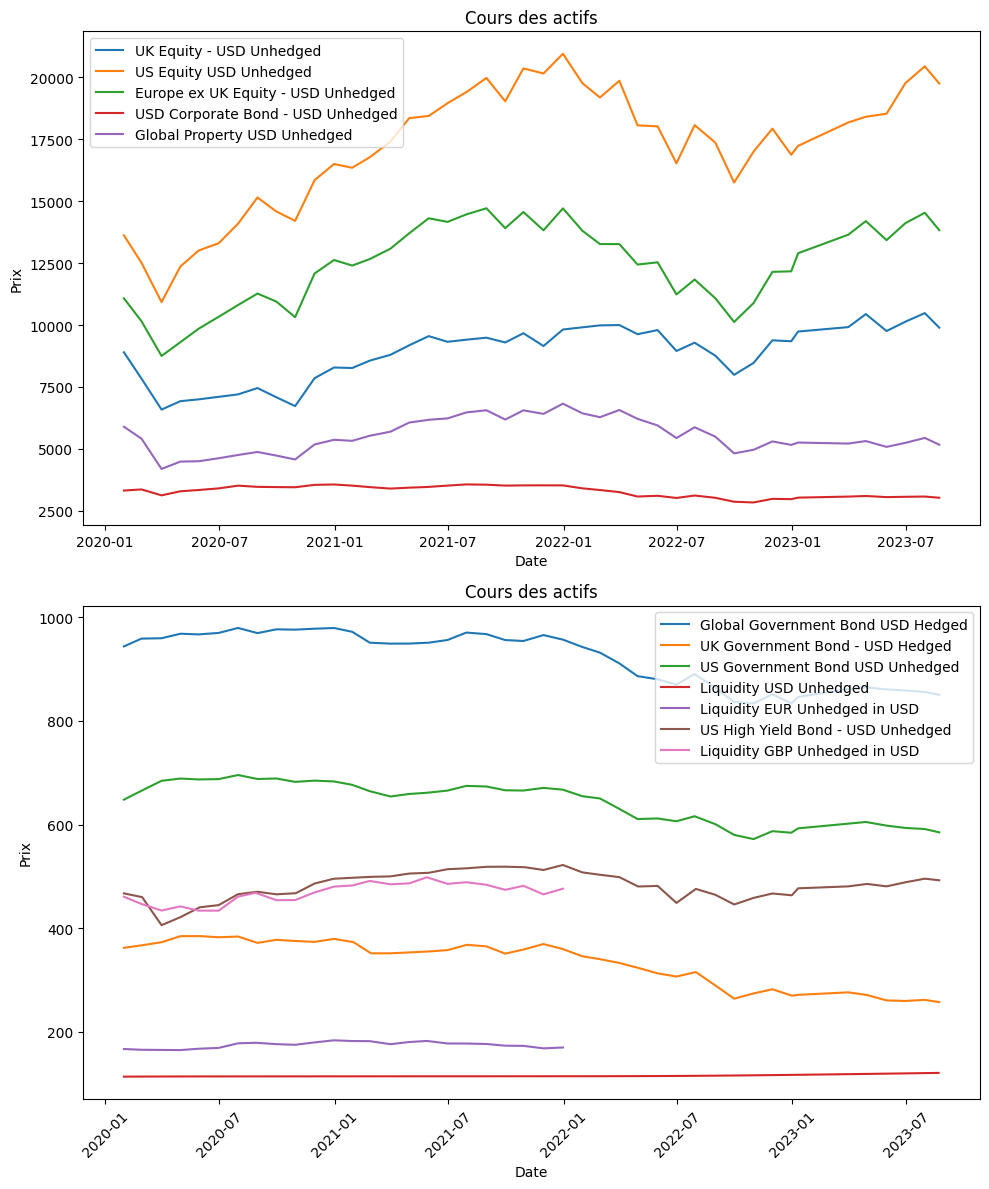

In [12]:
# Divise la liste d'actifs en deux sous-listes
liste_actifs1 = liste_actifs[:5] 
liste_actifs2 = liste_actifs[5:] 

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot pour la première liste d'actifs
for actif in liste_actifs1:
    data_actif = AssetTS_true[AssetTS_true['ASSETNAME'] == actif]
    simple_plot_date(data_actif['Date'], data_actif['PRICE'], 2020, title=f"Cours des actifs",asset_name=f"{actif}", ax=ax1)

# Plot pour la deuxième liste d'actifs
for actif in liste_actifs2:
    data_actif = AssetTS_true[AssetTS_true['ASSETNAME'] == actif]
    simple_plot_date(data_actif['Date'], data_actif['PRICE'], 2020, title=f"Cours des actifs",asset_name=f"{actif}", ax=ax2)

plt.tight_layout()
plt.show()

Les graphiques permettent de visualiser des corrélations entre les actifs avec des tendances communes. De plus, les séries ne semblent pas <u>stationnaires</u> (ie: $E(S_t)$ semble dépendre de t). Il sera donc compliqué de traité la série telle qu'elle dans un réseau de neuronne. On considère plutôt le LogReturn de la série, définie formellement par:

$ r_t = \ln\left(\frac{S_t}{S_{t-1}}\right) $

Où :
- $ S_t $ est le prix de l'actif à l'instant $ t $,
- $ \ln $ est la fonction logarithme naturel.

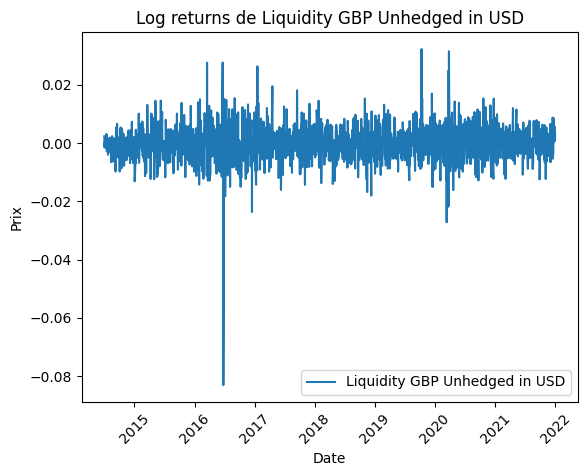

In [18]:
actif = "Liquidity GBP Unhedged in USD"
AssetTS['Log_Return'] = np.log(AssetTS[AssetTS['ASSETNAME'] == actif]['PRICE']).diff()
year = 2014
simple_plot_date(AssetTS[AssetTS['ASSETNAME']==actif]['Date'],AssetTS[AssetTS['ASSETNAME']==actif]['Log_Return'],year, title = f"Log returns de {actif}", asset_name=f"{actif}" )

# Description statistique

In [20]:
AssetTS['Log_Return'] = np.nan

for actif in liste_actifs:
    log_returns = np.log(AssetTS[AssetTS['ASSETNAME'] == actif]['PRICE']).diff()
    AssetTS.loc[AssetTS['ASSETNAME'] == actif, 'Log_Return'] = log_returns

/tmp/ipykernel_138815/1515170135.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(AssetTS[AssetTS['ASSETNAME'] == actif]['Log_Return'], hist=True, kde=True, label='VIX log-returns dist',
/home/onyxia/work/.venv/lib/python3.12/site-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/tmp/ipykernel_138815/1515170135.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use 

<Axes: xlabel='Log_Return', ylabel='Density'>

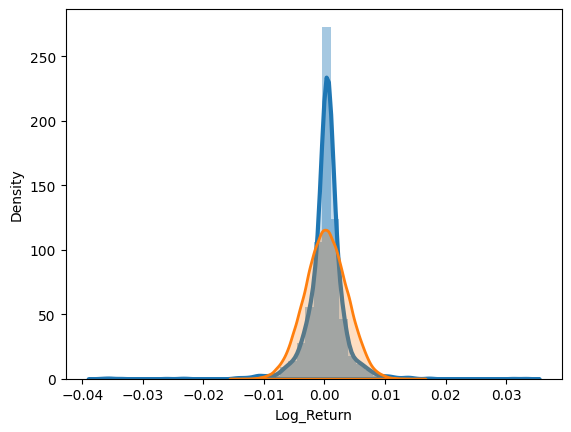

In [41]:
actif="US High Yield Bond - USD Unhedged"
m ,sd = AssetTS[AssetTS['ASSETNAME'] == actif]['Log_Return'].mean(), AssetTS[AssetTS['ASSETNAME'] == actif]['Log_Return'].std()
sb.distplot(AssetTS[AssetTS['ASSETNAME'] == actif]['Log_Return'], hist=True, kde=True, label='VIX log-returns dist', 
            kde_kws = {'shade': True, 'linewidth': 3})
sample = np.random.normal(m, sd, size=100000)
sb.distplot(sample, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2}, 
                  label = 'Gaussian Distribution with same mean/std')

On constate que la distribution n'est pas gaussienne. En effet on voit qu'elle est asymétrique et qu'elle est également leptokurtique (queues plus épaisses par rapport à la gaussienne). Donc approximer la série par une gaussienne n'est pas une très bonne idée. Il faudrait peut-être songer à enlever les valeurs extrêmes pour voir le comportement. (*Ici on a le graphique sur un actif mais on peut le vérifier sur chaque actif*).

QQplot des log-returns de Liquidity GBP Unhedged in USD


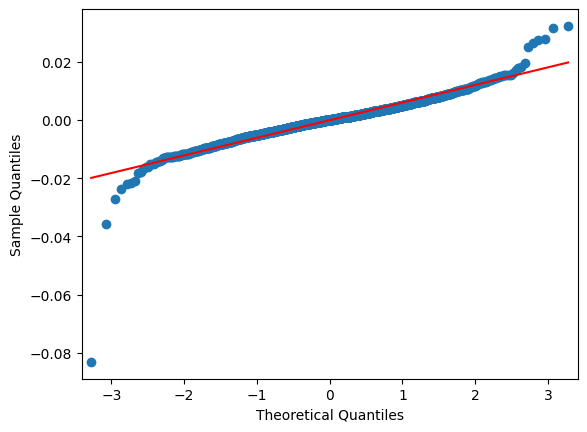

In [14]:
sdf = AssetTS[AssetTS['ASSETNAME'] == actif]['PRICE']
y = np.log(sdf/sdf.shift(1))[1:].to_numpy()
print(f'QQplot des log-returns de {actif}')
qqplot(y, line='s')
plt.show()


La distribution des valeurs de la série ne colle pas très bien avec une loi normale, on peut chercher à transformer la série (retirer les outliers par exemple) afin que la distribution s'approche d'une loi normale et justifier ainsi l'utilisation de modèles statistiques. 

L'intérêt du projet ici est de ne pas dépendre d'hypothèses qui peuvent être parfois peu vraisemblables (normalité des logs-returns par exemple). En faisant le moins de transformations possibles à la série, on cherche à entraîner un modèle pour générer des séries de prix sans avoir à poser d'hypothèses statistiques au préalable. Regardons si la série vérifie quelques faits stylisés.

# Faits stylisés séries 

In [18]:
def is_stationnary(serie, threshold, display_stats=True):
    result = adfuller(serie)
    if display_stats:
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
    if result[0] < result[4][threshold]:
        return True
    return False

In [19]:
is_stationnary(y, '5%', display_stats=True)

ADF Statistic: -18.175798
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


True